# Multi-Strategy Portfolio Construction and Risk Analysis (2020–2022)

## Description:
Constructed five portfolio strategies — Markowitz, Global Minimum Variance, Equally Weighted, Naïve Risk Parity, and Vanilla Risk Parity — using data from 2020–2022 for 9 major U.S. stocks. Evaluated each strategy's allocations, returns, Sharpe ratios, drawdowns, and risk contributions using Python-based optimization and visual analysis.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(42)

# ---- Setup ----
tickers = ['AAPL', 'WMT', 'TSLA', 'KO', 'BAC', 'T', 'META', 'NFLX', 'CRM']
start_date = '2020-01-01'
end_date = '2022-01-01'
prices = yf.download(tickers, start=start_date, end=end_date)['Close']
returns = prices.pct_change().dropna()
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
n = len(tickers)

# ---- Portfolio Optimizers ----

def get_equal_weights():
    return np.repeat(1/n, n)

def get_inv_vol_weights():
    vol = returns.std()
    inv_vol = 1 / vol
    return (inv_vol / inv_vol.sum()).values

def get_gmv_weights():
    def objective(w): return w.T @ cov_matrix @ w
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n
    res = minimize(objective, np.repeat(1/n, n), bounds=bounds, constraints=constraints)
    return res.x

def get_markowitz_weights():
    def objective(w): return -((w @ mean_returns) / np.sqrt(w.T @ cov_matrix @ w))
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n
    res = minimize(objective, np.repeat(1/n, n), bounds=bounds, constraints=constraints)
    return res.x

def get_risk_parity_weights():
    def risk_contrib(w): return w * (cov_matrix @ w)
    def objective(w):
        rc = risk_contrib(w)
        return np.sum((rc - rc.mean()) ** 2)
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n
    res = minimize(objective, np.repeat(1/n, n), bounds=bounds, constraints=constraints)
    return res.x


# ---- Run Evaluations ----

weights = {
    "Markowitz": get_markowitz_weights(),
    "Global Min Var": get_gmv_weights(),
    "Equal Weighted": get_equal_weights(),
    "Inverse Volatility": get_inv_vol_weights(),
    "Vanilla Risk Parity": get_risk_parity_weights()
}
weights

/var/folders/rf/w1c5pmc51gvg00xtlws6z9nh0000gn/T/ipykernel_19396/1193508057.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  9 of 9 completed


{'Markowitz': array([3.09482654e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.22055140e-03, 8.13652527e-17, 6.13801720e-01,
        6.94950751e-02]),
 'Global Min Var': array([0.00000000e+00, 8.98464805e-20, 1.08944405e-17, 2.78957346e-01,
        1.92794007e-02, 1.16547485e-01, 1.73416555e-01, 0.00000000e+00,
        4.11799213e-01]),
 'Equal Weighted': array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111]),
 'Inverse Volatility': array([0.10728577, 0.08885037, 0.09485803, 0.1502306 , 0.10415498,
        0.10105953, 0.14021556, 0.05406632, 0.15927884]),
 'Vanilla Risk Parity': array([0.11012048, 0.11337594, 0.10647256, 0.12629307, 0.11236769,
        0.11784111, 0.12668294, 0.05903873, 0.12780748])}

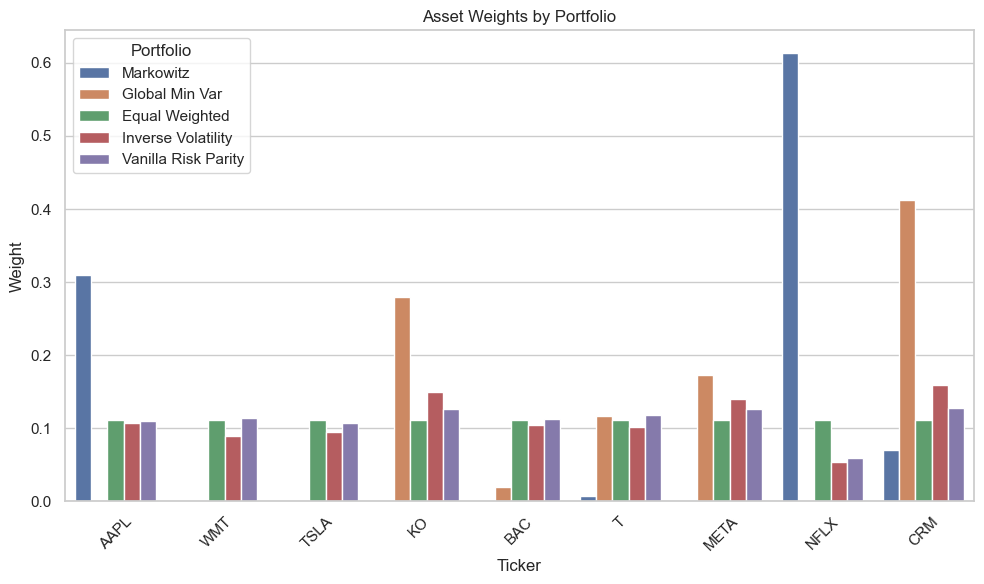

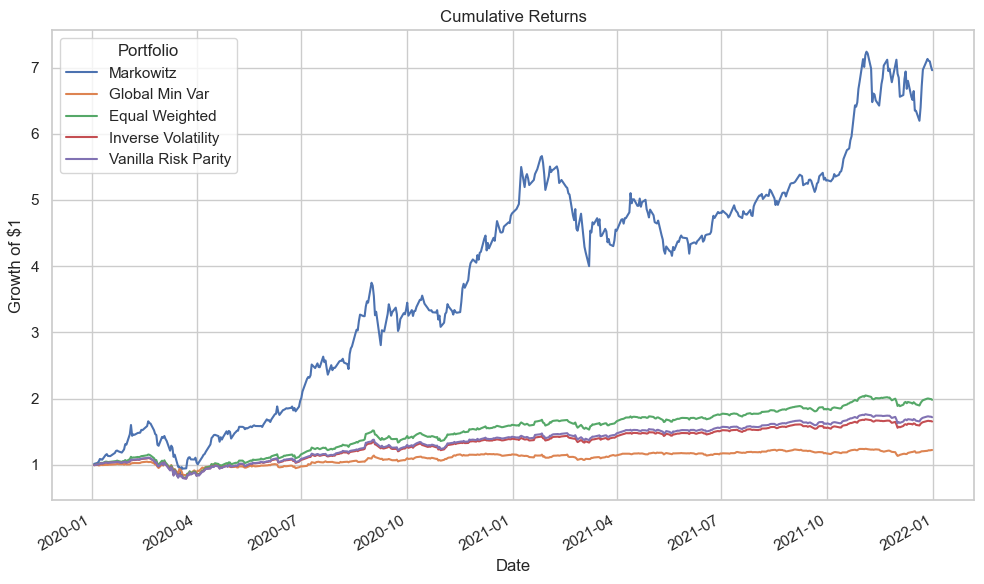

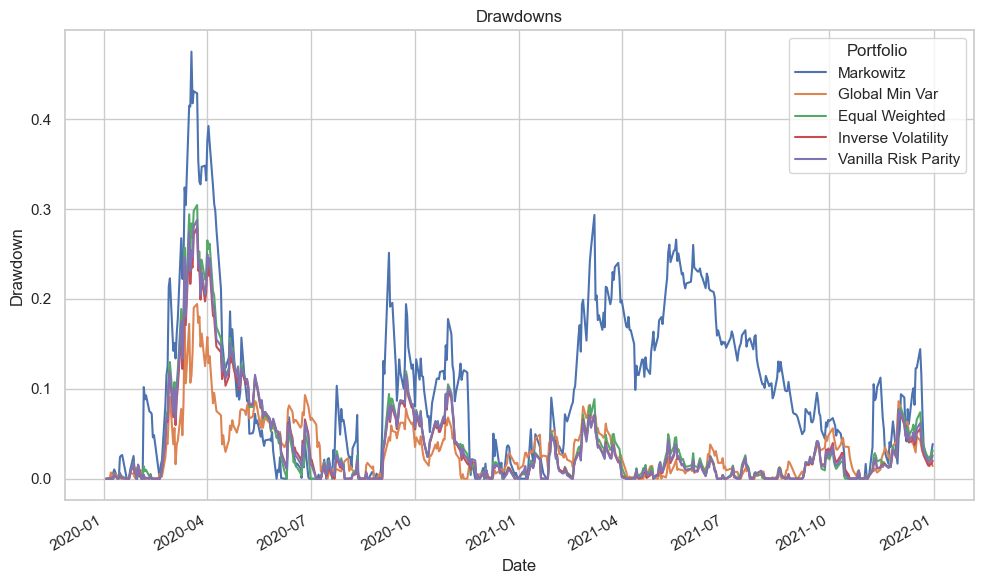

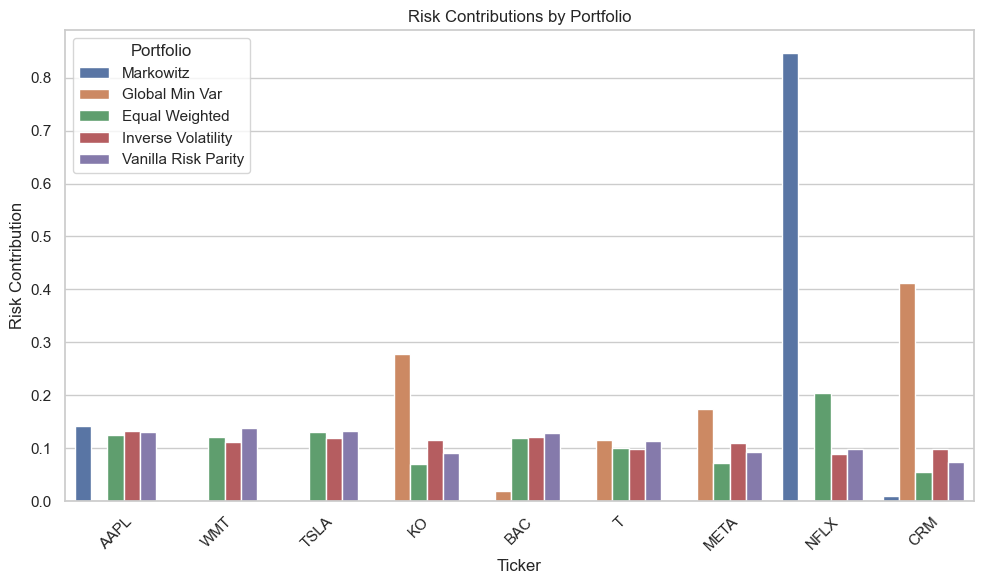

In [2]:
def plot_weights(weights_dict):
    df = pd.DataFrame(weights_dict,index = tickers).T
    df = df.reset_index().melt(id_vars='index', var_name='Ticker', value_name='Weight')
    df.rename(columns={'index': 'Portfolio'}, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Ticker', y='Weight', hue='Portfolio')
    plt.title("Asset Weights by Portfolio")
    plt.ylabel("Weight")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_cumulative_returns(cum_returns_dict):
    df = pd.DataFrame(cum_returns_dict)
    plt.figure(figsize=(10, 6))
    df.plot(ax=plt.gca())
    plt.title("Cumulative Returns")
    plt.ylabel("Growth of $1")
    plt.xlabel("Date")
    plt.legend(title="Portfolio")
    plt.tight_layout()
    plt.show()

def plot_drawdowns(drawdown_dict):
    df = pd.DataFrame(drawdown_dict)
    plt.figure(figsize=(10, 6))
    df.plot(ax=plt.gca())
    plt.title("Drawdowns")
    plt.ylabel("Drawdown")
    plt.xlabel("Date")
    plt.legend(title="Portfolio")
    plt.tight_layout()
    plt.show()

def plot_risk_contrib(rc_dict):
    df = pd.DataFrame(rc_dict).T
    df.columns = tickers
    df = df.reset_index().melt(id_vars='index', var_name='Ticker', value_name='Risk Contribution')
    df.rename(columns={'index': 'Portfolio'}, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Ticker', y='Risk Contribution', hue='Portfolio')
    plt.title("Risk Contributions by Portfolio")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def evaluate(weights):
    port_returns = returns @ weights
    cum_returns = (1 + port_returns).cumprod()
    hwm = cum_returns.cummax()
    drawdown = (hwm - cum_returns) / hwm
    risk_contrib = weights * (cov_matrix @ weights)
    risk_contrib /= risk_contrib.sum()
    return cum_returns, drawdown, risk_contrib

rc = {}
dd = {}
cr = {}

for name, weight in weights.items():
    cum_returns, drawdown, risk_contrib = evaluate(weight)
    cr[name] = cum_returns
    dd[name] = drawdown
    rc[name] = risk_contrib
plot_weights(weights)
plot_cumulative_returns(cr)
plot_drawdowns(dd)
plot_risk_contrib(rc)
# ---- Summary ----

